In [44]:
import scipy.interpolate
import astropy.table
import numpy
import time
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import  LineString

def read_pms_data(tracks="BHAC15"):

    # Load in the data for the appropriate set of evolutionary tracks.

    path = './evolutionary_tracks/'
    
    if tracks == "BHAC15":
        f = open(path+"BHAC15_tracks+structure.txt","r")
        lines = f.readlines()
        f.close()

        colnames = lines[46].split()[1:]

        data = numpy.loadtxt(path+"BHAC15_tracks+structure.txt", comments="!", \
                skiprows=45)
    elif tracks == "Siess2000":
        f = open(path+"siess_2000/m0.13z02.hrd")
        lines = f.readlines()
        f.close()

        line1 = lines[0].replace(" (","_(").replace("log g","logg").\
                replace("#","").replace("_(Lo)","/Ls").replace("age_","log_t").\
                split()
        line2 = lines[1].replace(" (","_(").replace("log g","logg").\
                replace("#","").replace("_(Mo)","/Ms").split()

        colnames = line1 + line2
        colnames[0::2] = line1
        colnames[1::2] = line2

        files = glob.glob(path+"siess_2000/*.hrd")
        for file in files:
            try:
                data = numpy.concatenate((data, numpy.loadtxt(file)))
            except:
                data = numpy.loadtxt(file)

        # Fix the stellar luminosity.

        data[:,2] = numpy.log10(data[:,2])
        data[:,-1] = numpy.log10(data[:,-1])
    elif tracks == "Dotter2008":
        f = open(path+"dotter2008/m200fehp00afep0.trk")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = ['M/Ms'] + lines[1].replace("Log ","Log").\
                replace("Age ","log_t").replace("LogT","Teff").\
                replace("LogL","L/Ls").replace("yrs","yr").split()[1:]

        # Now read in the data files.

        files = glob.glob(path+"dotter2008/*.trk")
        for file in files:
            new_data = numpy.loadtxt(file)

            # add a column with the mass of the star.

            mass = float(file.split("/")[-1][1:4])/100.
            mass_arr = numpy.zeros((new_data.shape[0],1)) + mass
            new_data = numpy.hstack((mass_arr, new_data))

            # Merge with existing data.

            try:
                data = numpy.concatenate((data, new_data))
            except:
                data = new_data.copy()

        # Get rid of ages more than ~50Myr.

        good = data[:,1] < 50.0e6
        data = data[good,:]

        # Fix some of the columns.

        data[:,1] = numpy.log10(data[:,1])
        data[:,2] = 10.**data[:,2]

    elif tracks == "Tognelli2011":
        f = open(path+"tognelli2011/Z0.02000_Y0.2700_XD2E5_ML1.68_AS05/"
                "TRK_M0.20_Z0.02000_Y0.2700_XD2E5_ML1.68_AS05.DAT")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = ['M/Ms'] + lines[3].replace("LOG ","LOG_").\
                replace("LOG_AGE","log_t(yr)").replace("LOG_L","L/Ls").\
                replace("LOG_TE","Teff").split()[1:]

        # Now read in the data files.

        files = glob.glob(path+"tognelli2011/"
                "Z0.02000_Y0.2700_XD2E5_ML1.68_AS05/*.DAT")
        for file in files:
            new_data = numpy.loadtxt(file)

            # add a column with the mass of the star.

            mass = float(file.split("/")[-1].split("_")[1][1:])
            mass_arr = numpy.zeros((new_data.shape[0],1)) + mass
            new_data = numpy.hstack((mass_arr, new_data))

            # Merge with existing data.

            try:
                data = numpy.concatenate((data, new_data))
            except:
                data = new_data.copy()

        # Fix some of the columns.

        data[:,5] = 10.**data[:,5]

    elif tracks == "Feiden2016":
        f = open(path+"feiden2016/std/"
                "m0090_GS98_p000_p0_y28_mlt1.884.trk")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = ['M/Ms'] + lines[3].replace("Log ","Log").\
                replace("Age ","log_t").replace("LogT","Teff").\
                replace("LogL","L/Ls").replace("yrs","yr").split()[1:6]

        # Now read in the data files.

        files = glob.glob(path+"feiden2016/std/*.trk")
        for file in files:
            new_data = numpy.loadtxt(file, usecols=(0,1,2,3,4))

            # add a column with the mass of the star.

            mass = float(file.split("/")[-1][1:5])/1000.
            mass_arr = numpy.zeros((new_data.shape[0],1)) + mass
            new_data = numpy.hstack((mass_arr, new_data))

            # Merge with existing data.

            try:
                data = numpy.concatenate((data, new_data))
            except:
                data = new_data.copy()

        # Get rid of ages more than ~50Myr.

        good = data[:,1] < 50.0e6
        data = data[good,:]

        # Fix some of the columns.

        data[:,1] = numpy.log10(data[:,1])
        data[:,2] = 10.**data[:,2]

    elif tracks == "Feiden2016mag":
        f = open(path+"feiden2016/mag/"
                "m1700_GS98_p000_p0_y28_mlt1.884_mag08kG.ntrk")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = ['M/Ms'] + lines[8].replace("conv. ","conv.").\
                replace("AGE","log_t(yr)").replace("log(Teff)","Teff").\
                replace("log(L/Lsun)","L/Ls").replace("Model #","Model#").\
                replace("M He core","M_He_core").replace(",","").split()[1:]

        # Now read in the data files.

        files = glob.glob(path+"feiden2016/mag/*.ntrk")
        for file in files:
            new_data = numpy.loadtxt(file,usecols=tuple([i for i in range(12)]))

            # add a column with the mass of the star.

            mass = float(file.split("/")[-1][1:5])/1000.
            mass_arr = numpy.zeros((new_data.shape[0],1)) + mass
            new_data = numpy.hstack((mass_arr, new_data))

            # Merge with existing data.

            try:
                data = numpy.concatenate((data, new_data))
            except:
                data = new_data.copy()

        # Fix some of the columns.

        data[:,3] = numpy.log10(data[:,3]*1.0e9)
        data[:,7] = 10.**data[:,7]

    elif tracks == "Chen2014":
        f = open(path+"bressan2012/Z0.017Y0.279/"
                "Z0.017Y0.279OUTA1.77_F7_M000.700.DAT")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = lines[0].replace("LOG ","LOG_").\
                replace("AGE","log_t(yr)").replace("LOG_L","L/Ls").\
                replace("LOG_TE","Teff").replace("MASS","M/Ms").split()

        # Now read in the data files.

        files = glob.glob(path+"bressan2012/Z0.017Y0.279/*.DAT")

        for file in files:
            new_data = numpy.loadtxt(file, skiprows=2)

            # Merge with existing data.

            try:
                data = numpy.concatenate((data, new_data))
            except:
                data = new_data.copy()

        # Get rid of ages more than ~50Myr.

        good = data[:,2] < 50.0e6
        data = data[good,:]

        # Fix some of the columns.

        data[:,2] = numpy.log10(data[:,2])
        data[:,4] = 10.**data[:,4]

    elif tracks == "Bressan2012":
        f = open(path+"bressan2012/bressan2012.dat")
        lines = f.readlines()
        f.close()

        # Get the column names.

        colnames = lines[13].replace("log(age/yr)","log_t(yr)").\
                replace("logL/Lo","L/Ls").replace("logTe","Teff").\
                replace("M_act","M/Ms").split()[1:]

        # Now read in the data files.

        data = numpy.loadtxt(path+"bressan2012/bressan2012.dat")

        # Fix some of the columns.

        data[:,5] = 10.**data[:,5]

    # Make the data into a table.

    table = astropy.table.Table(data, names=colnames)

    # Return the table now.

    return table


def pms_get_mstar(age=None, luminosity=None, tracks="BHAC15"):

    # Load in the data for the appropriate set of evolutionary tracks.

    table = read_pms_data(tracks=tracks)

    # Now do the 2D interpolation.

    Mstar = scipy.interpolate.LinearNDInterpolator((table["L/Ls"], \
            table["log_t(yr)"]), table["M/Ms"], rescale=True)

    # Finally, get the stellar mass.

    if isinstance(age,float) and isinstance(luminosity,float):
        xi = numpy.array([[luminosity, numpy.log10(age)]])
    elif isinstance(age,float):
        xi = numpy.array([[luminosity[i],numpy.log10(age)] for i in range(len(luminosity))])
    else:    
        xi = numpy.array([[luminosity[i],numpy.log10(age[i])] for i in \
                range(len(age))])

    return Mstar(xi)

def pms_get_teff(luminosity = None, age=1.0e6, tracks="BHAC15"):

    # Load in the data for the appropriate set of evolutionary tracks.

    table = read_pms_data(tracks=tracks)

    # Now do the 2D interpolation.

    Teff = scipy.interpolate.LinearNDInterpolator((table["L/Ls"], \
            table["log_t(yr)"]), table["Teff"])

    # Finally, get the stellar mass.

    if isinstance(age,float) and isinstance(luminosity,float):
        xi = numpy.array([[luminosity, numpy.log10(age)]])
    elif isinstance(age,float):
        xi = numpy.array([[luminosity[i],numpy.log10(age)] for i in range(len(mass))])
    else:
        xi = numpy.array([[luminosity[i],numpy.log10(age[i])] for i in range(len(age))])

    return Teff(xi)

def pdspy_get_teff(mass=1.0, age=1.0e6, tracks="BHAC15"):

    # Load in the data for the appropriate set of evolutionary tracks.

    table = read_pms_data(tracks=tracks)

    # Now do the 2D interpolation.

    Teff = scipy.interpolate.LinearNDInterpolator((table["M/Ms"], \
            table["log_t(yr)"]), table["Teff"])

    # Finally, get the stellar mass.
    
    if isinstance(age,float) and isinstance(mass,float):
        xi = numpy.array([[mass, numpy.log10(age)]])
    elif isinstance(age,float):
        xi = numpy.array([[mass[i],numpy.log10(age)] for i in range(len(mass))])
    else:
        xi = numpy.array([[mass,numpy.log10(age[i])] for i in range(len(age))])

    return Teff(xi)

def pdspy_get_luminosity(mass=1.0, age=1.0e6, tracks="BHAC15"):

    # Load in the data for the appropriate set of evolutionary tracks.

    table = read_pms_data(tracks=tracks)

    # Now do the 2D interpolation.

    Lstar = scipy.interpolate.LinearNDInterpolator((table["M/Ms"],\
            table["log_t(yr)"]), table["L/Ls"])

    # Finally, get the stellar mass.

    if isinstance(age,float) and isinstance(mass,float):
        xi = numpy.array([[mass, numpy.log10(age)]])
    elif isinstance(age,float):
        xi = numpy.array([[mass[i],numpy.log10(age)] for i in range(len(mass))])
    else:
        xi = numpy.array([[mass,numpy.log10(age[i])] for i in range(len(age))])

    return 10.**Lstar(xi)



In [45]:
colors_yr = ["#D4E6F1","#A9CCE3","#7FB3D5","#5499C7","#2980B9","#2471A3","#1F618D","#1A5276", "#154360"]
colors_mass = ["#F9E79F","#F9E79F","#F7DC6F","#F7DC6F","#F4D03F","#F4D03F","#F1C40F","#D4AC0D","#B7950B","#9A7D0A","#7D6608","#7D6608"]

In [46]:
# plot evolutionary tracks

ag = np.arange(0.5, 5,0.5)
ms = np.arange(0.2, 1.4, 0.1)
fig, axs=plt.subplots(1,2, figsize=(10,4),gridspec_kw={'width_ratios': [3, 1.2]})
ax = axs[0]
axs[1].axis("off")
# ax = plt.subplot(121)
for mas in ms:
    lum = pdspy_get_luminosity(mass=mas, age=ag*1e6, tracks="BHAC15")
    tef = pdspy_get_teff(mass=mas, age=ag*1e6, tracks="BHAC15")
    ax.plot(tef, lum, label=f'{mas:.1f} M_sun', c=colors_mass[np.where(ms == mas)[0][0]])

    
for agg in ag:
    lum = pdspy_get_luminosity(mass=ms, age=agg*1e6, tracks="BHAC15")
    tef = pdspy_get_teff(mass=ms, age=agg*1e6, tracks="BHAC15")
    ax.plot(tef, lum, label=f'{agg} yr', c=colors_yr[np.where(ag == agg)[0][0]])


ax.set_ylabel('$L_{bol}$/$L_{sun}$',fontsize=16)
ax.set_xlabel('Effective temperature/K',fontsize=16)
ax.set_title('Interpolation of Evolutionary Tracks BHAC15')
ax.invert_xaxis()
ax.set_yscale("log")
ax.legend(bbox_to_anchor=(1.05, 1),loc='upper left', ncol=2)

direc = 'pictures_evolutionary_tracks'
os.makedirs(direc, exist_ok=True)
plt.savefig(os.path.join(direc, f'Evolutionary_tracks.pdf'))
plt.close()




In [43]:
# derivation process to find mass by using evolutionary tracks

ag = np.arange(0.5, 5,0.5)
ms = np.arange(0.2, 1.4, 0.1)
fig, axs=plt.subplots(1,2, figsize=(10,4),gridspec_kw={'width_ratios': [3, 1.2]})
ax = axs[0]
axs[1].axis("off")
# ax = plt.subplot(121)
for mas in ms:
    lum = pdspy_get_luminosity(mass=mas, age=ag*1e6, tracks="BHAC15")
    tef = pdspy_get_teff(mass=mas, age=ag*1e6, tracks="BHAC15")
    ax.plot(tef, lum, label=f'{mas:.1f} M_sun', c=colors_mass[np.where(ms == mas)[0][0]])
    
    if mas == ms[3]:
        f = lum
        x1 = tef
    
for agg in ag:
    lum = pdspy_get_luminosity(mass=ms, age=agg*1e6, tracks="BHAC15")
    tef = pdspy_get_teff(mass=ms, age=agg*1e6, tracks="BHAC15")
    ax.plot(tef, lum, label=f'{agg} yr', c=colors_yr[np.where(ag == agg)[0][0]])
    
    if agg == 1.0:
        g = lum
        x2 = tef


line_1 = LineString(np.column_stack((x1, f)))
line_2 = LineString(np.column_stack((x2, g)))
intersection = line_1.intersection(line_2)


# plt.axvline(x=intersection.x, color = 'grey', label = 'intersection point')
ax.plot(x1,f,'c',linestyle='dashed', label='Provided Age')
ax.axhline(y=intersection.y, linestyle='dashed', color = 'c', label='Provided Luminosity')
ax.plot(*intersection.xy, 'ro', label='intersection point')
ax.plot(x2,g,'r',linestyle='dashed', label='Derived Mass')

ax.set_ylabel('$L_{bol}$/$L_{sun}$',fontsize=16)
ax.set_xlabel('Effective temperature/K',fontsize=16)
ax.set_title('Interpolation of Evolutionary Tracks BHAC15')
ax.invert_xaxis()
ax.set_yscale("log")
ax.legend(bbox_to_anchor=(1.05, 1),loc='upper left', ncol=2)

direc = 'pictures_evolutionary_tracks'
os.makedirs(direc, exist_ok=True)
plt.savefig(os.path.join(direc, f'Evolutionary_tracks_interpolation_process.pdf'))
plt.close()



In [ ]:
import numpy as np
import numpy.random as random
import statistics
import matplotlib.pyplot as plt
from matplotlib import colors

def monte_carlo(flux=5.6e-2, D=0.4):
    b = random.normal(-2.66, 0.06, 1000)
    m = random.normal(0.91, 0.06, 1000)
    flux_al = random.normal(flux, 0.1*flux, 1000)
    L_bol_al = []

    lum = flux_al * (D**2)
    for i in range(1000):
        L_bol_al.append((np.log10(lum[i]) - b[i])/m[i])
    L_bol_mean = statistics.mean(L_bol_al)
    L_bol_std = statistics.stdev(L_bol_al)
    return L_bol_al, L_bol_mean, L_bol_std
    
def plot_hist(flux, arr, mean, typ='exponent'):
    N, bins, patches = plt.hist(arr, bins=100)
    max_index = np.argmax(N)
    max_value = bins[max_index]

    fracs = N / N.max()
    norm = colors.Normalize(fracs.min(), fracs.max())

    for thisfrac, thispatch in zip(fracs, patches):
        color = plt.cm.viridis(norm(thisfrac))
        thispatch.set_facecolor(color)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1, label = 'average')
    plt.axvline(max_value, color='b', linestyle='dashed', linewidth=1, label = 'most frequent')
    plt.legend()
    if typ =='exponent':
        plt.xlabel('exponent of L_bol')
        plt.ylabel('frequency')
        print(f'most frequent result for {flux} mJy is: {max_value}')
    elif typ =='mass':
        plt.xlabel('mass of the object')
        plt.ylabel('frequency')
        print(f'most frequent result for {flux} mJy is: {max_value} solar mass')
    return max_value

In [ ]:
def find_flux(flux, lam_in, lam_out, exp=-0.1):
    f_in = 3.0e8/lam_in
    f_out = 3.0e8/lam_out
    return flux*(f_out/f_in)**(exp)
    

In [4]:
def set_axis_style(ax, labels):
    ax.xaxis.set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(labels) + 1))
    ax.set_xticklabels(labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Sample name')

In [19]:
import os
def plot_violin(mass_1y_e056, mass_1y_en01, mass_05y_e056, mass_05y_en01, name):
    fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10), sharey=True)
    ax1.set_title(f'{name}_0.56exp_1byr')
    ax1.set_ylabel('mass/M_sun')
    ax1.violinplot(mass_1y_e056)
    ax2.set_title(f'{name}_n0.1exp_1byr')
    ax2.set_ylabel('mass/M_sun')
    ax2.violinplot(mass_1y_en01)
    ax3.set_title(f'{name}_0.56exp_0.5byr')
    ax3.set_ylabel('mass/M_sun')
    ax3.violinplot(mass_05y_e056)
    ax4.set_title(f'{name}_n0.1exp_0.5byr')
    ax4.set_ylabel('mass/M_sun')
    ax4.violinplot(mass_05y_en01)

    labels = ["A", "B", "C","D","E","F","G","H"]
    for ax in [ax1, ax2, ax3, ax4]:
        set_axis_style(ax, labels)
    fig.tight_layout()
    direc = 'pictures'
    os.makedirs(direc, exist_ok=True)
    plt.savefig(os.path.join(direc, f'{name}.png'))
    plt.close()

{'name': 'HOPS-56', 'frequency': 33000000000.0, 'flux': 5.69e-05}


<IPython.core.display.Javascript object>


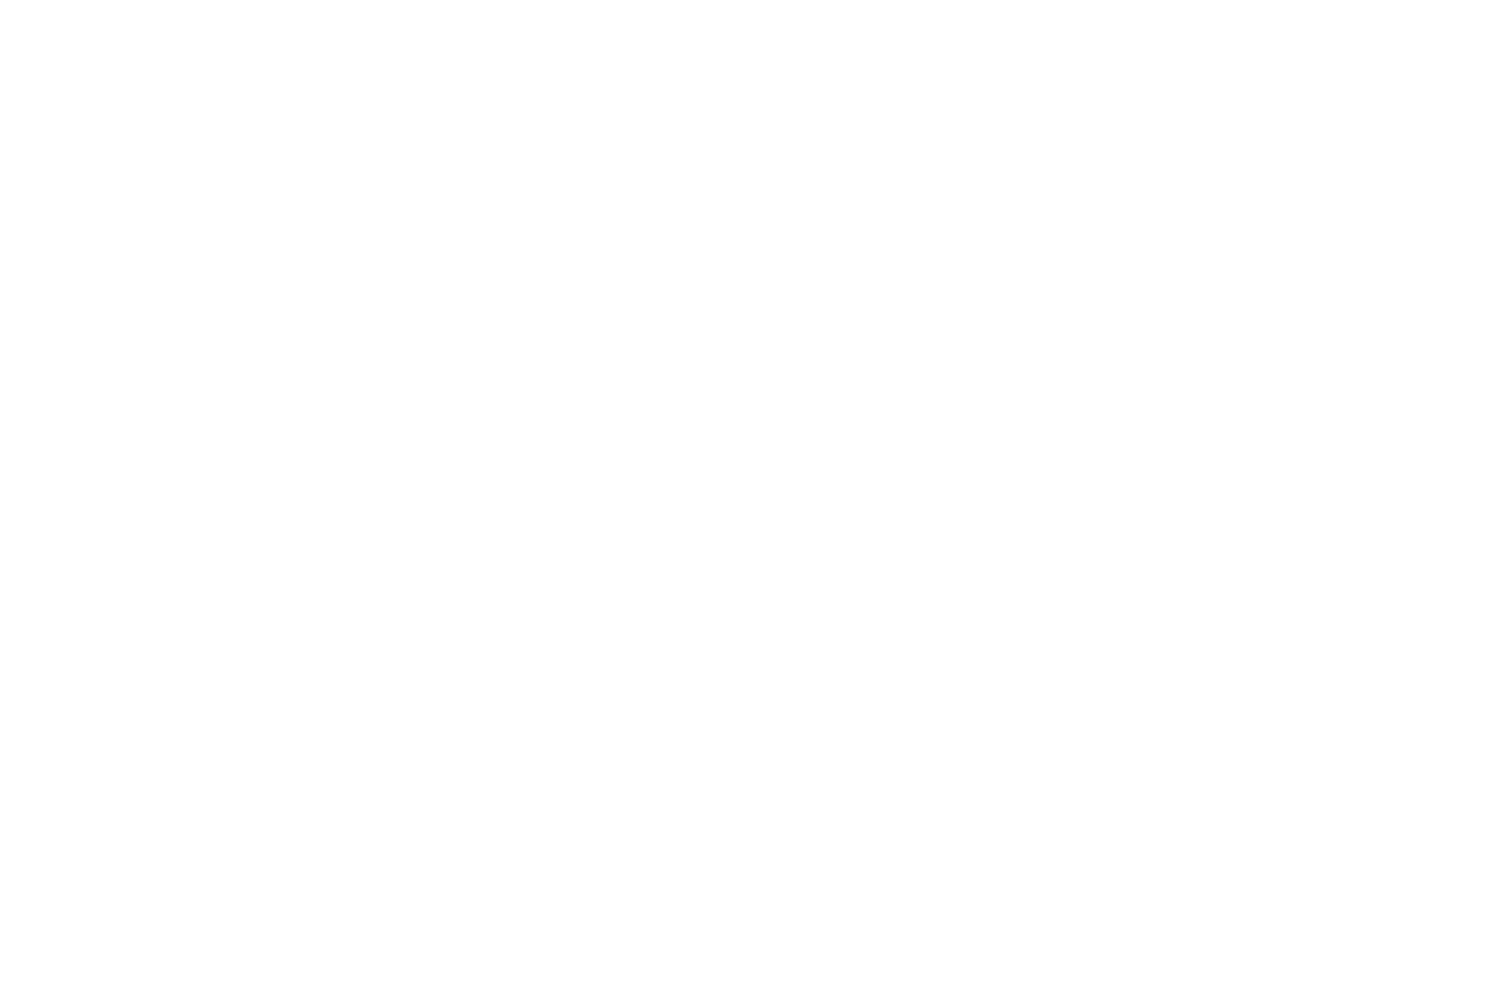

{'name': 'HOPS-56', 'frequency': 33000000000.0, 'flux': 2.3429999999999998e-05}


<IPython.core.display.Javascript object>


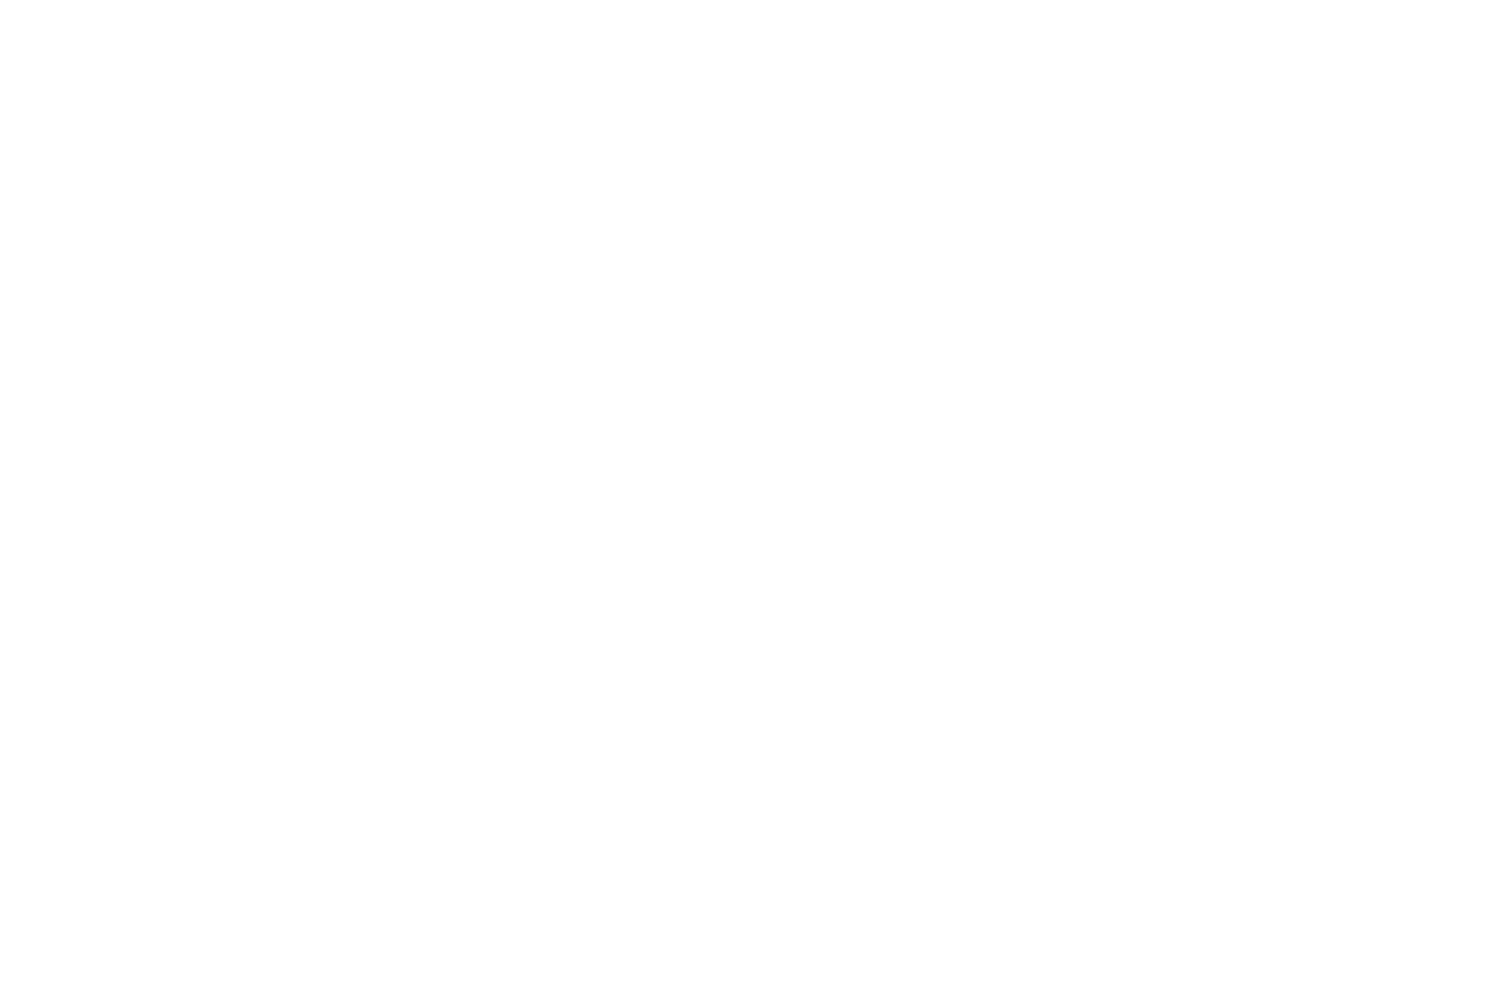

{'name': 'HOPS-65', 'frequency': 15000000000.0, 'flux': 1.064e-05}


<IPython.core.display.Javascript object>


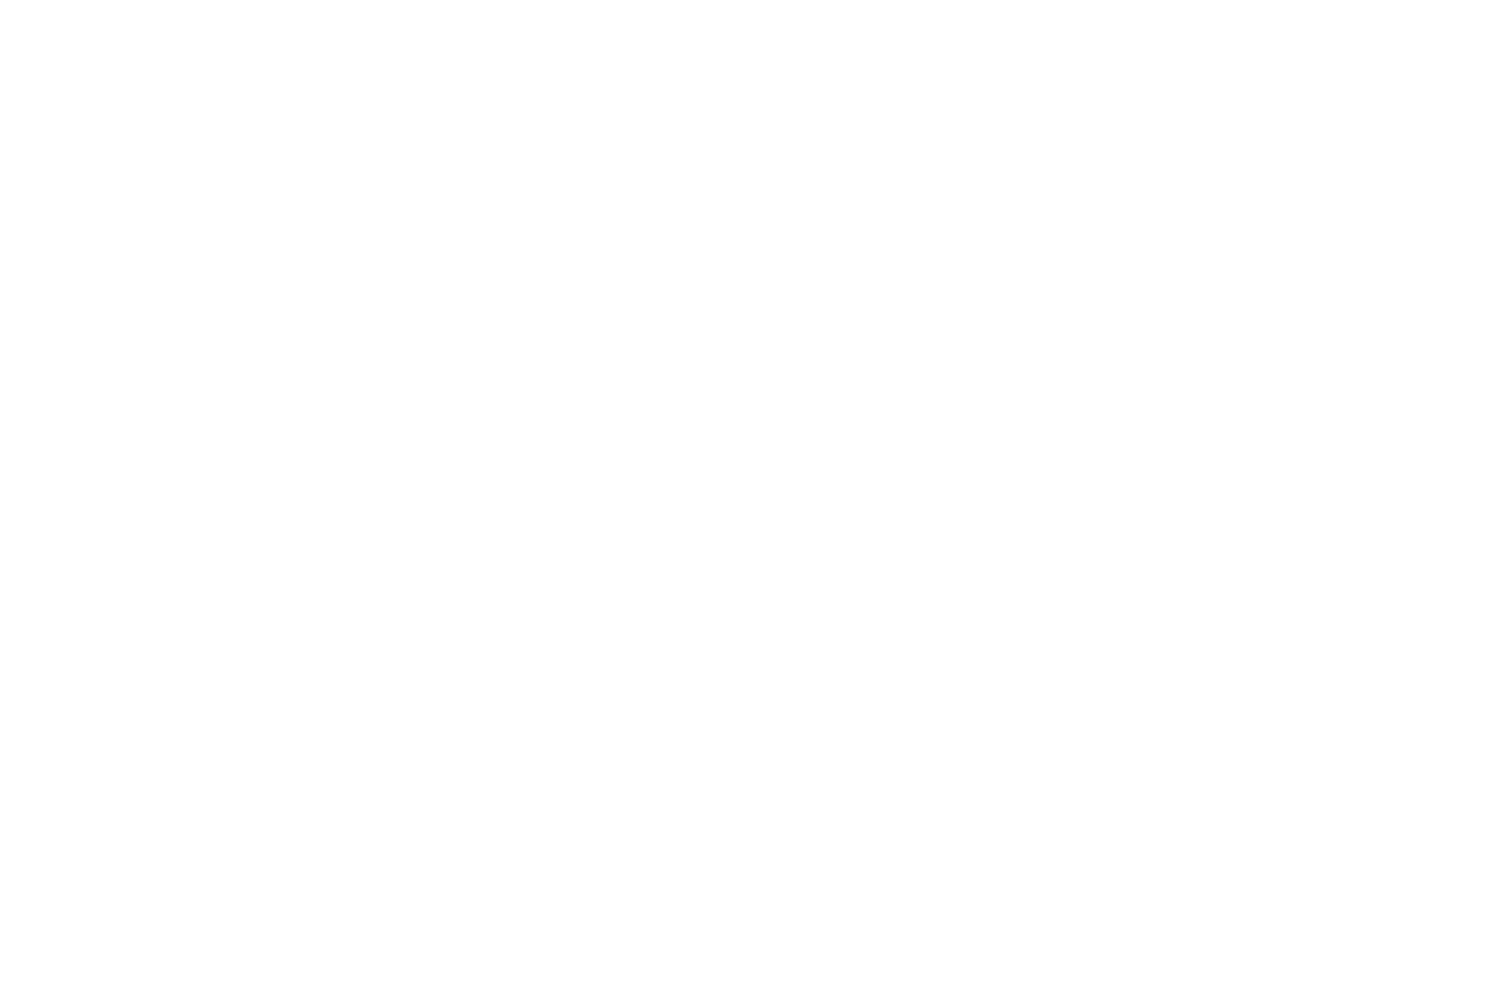

{'name': 'HOPS-65', 'frequency': 15000000000.0, 'flux': 7.319999999999999e-06}


<IPython.core.display.Javascript object>


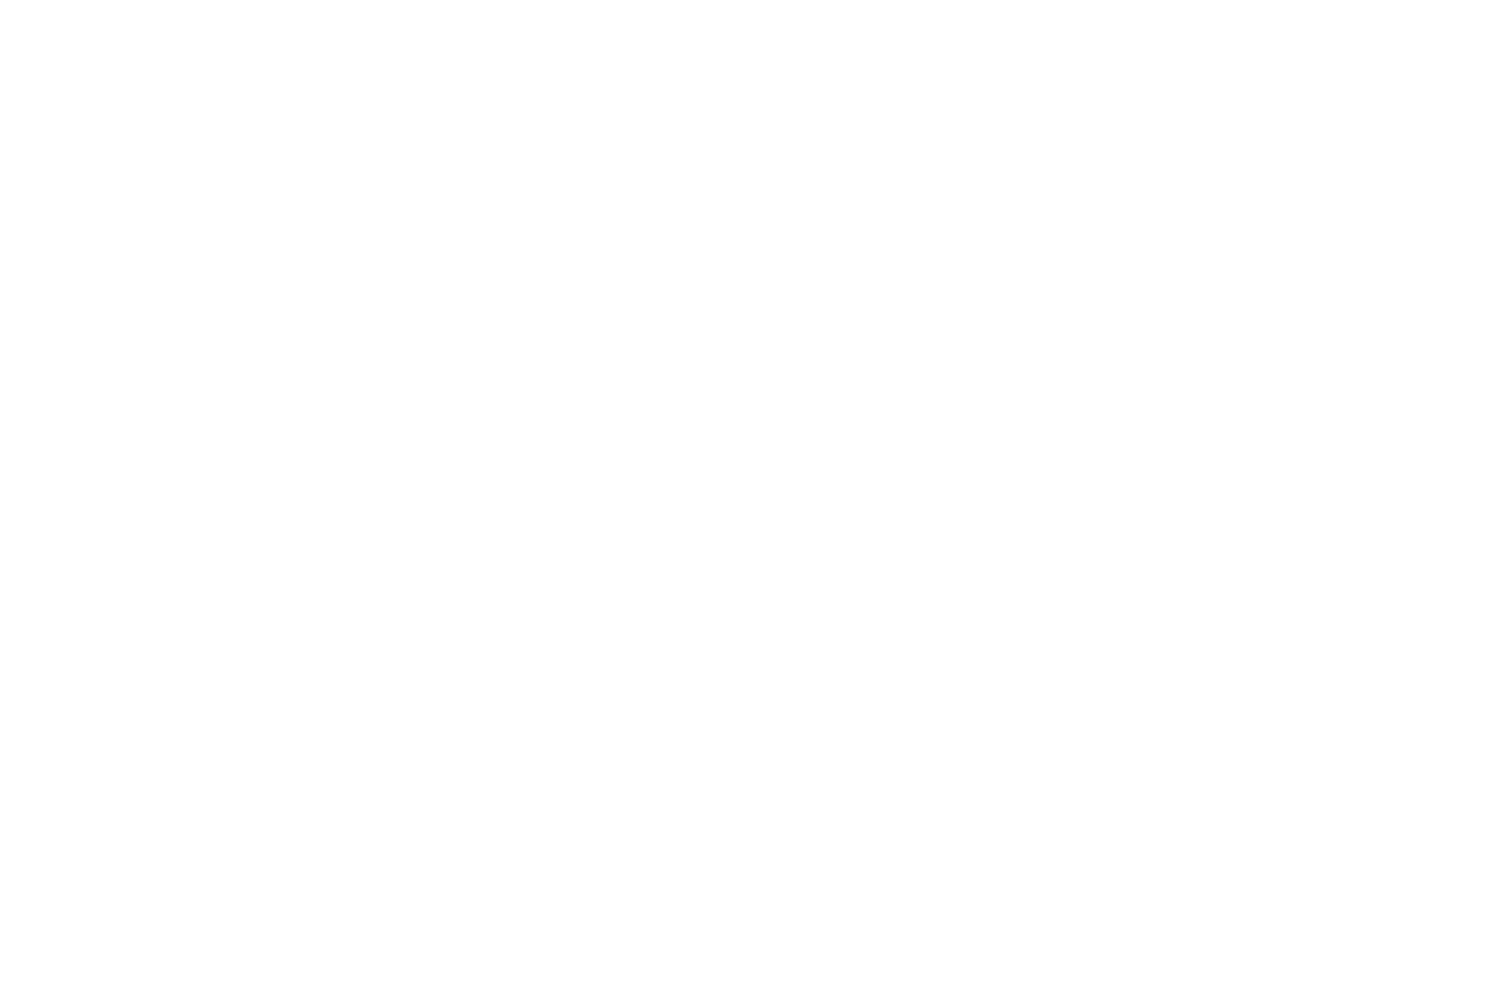

{'name': 'HOPS-124', 'frequency': 44000000000.0, 'flux': 0.0005424}


<IPython.core.display.Javascript object>


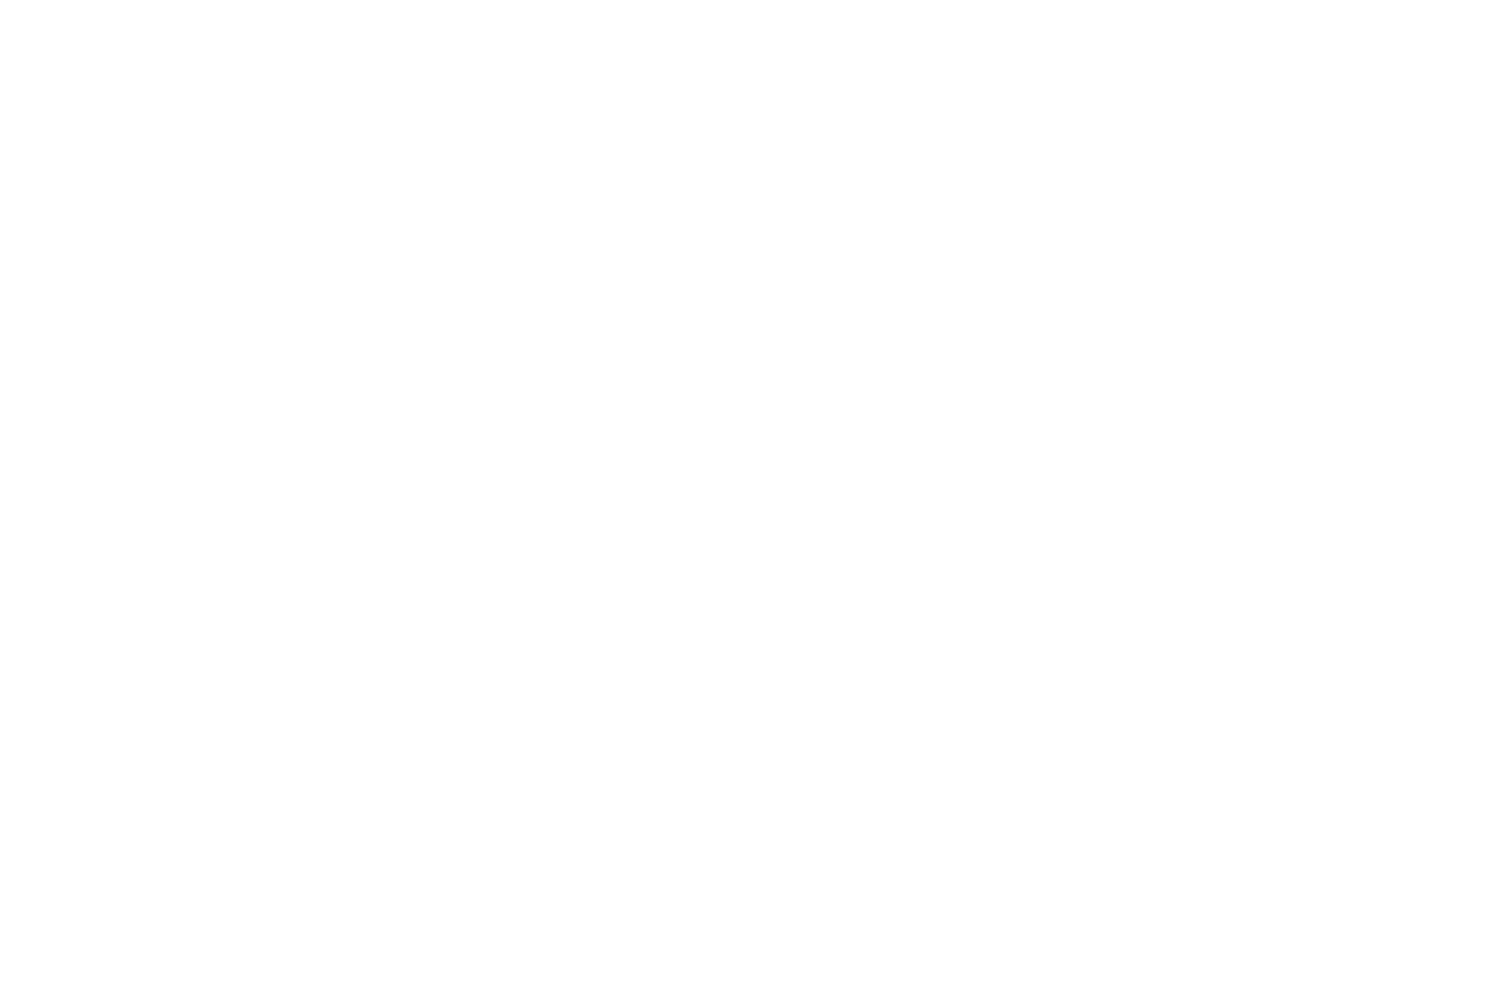

{'name': 'HOPS-56', 'frequency': 33000000000.0, 'flux': 2.3429999999999998e-05}


<IPython.core.display.Javascript object>


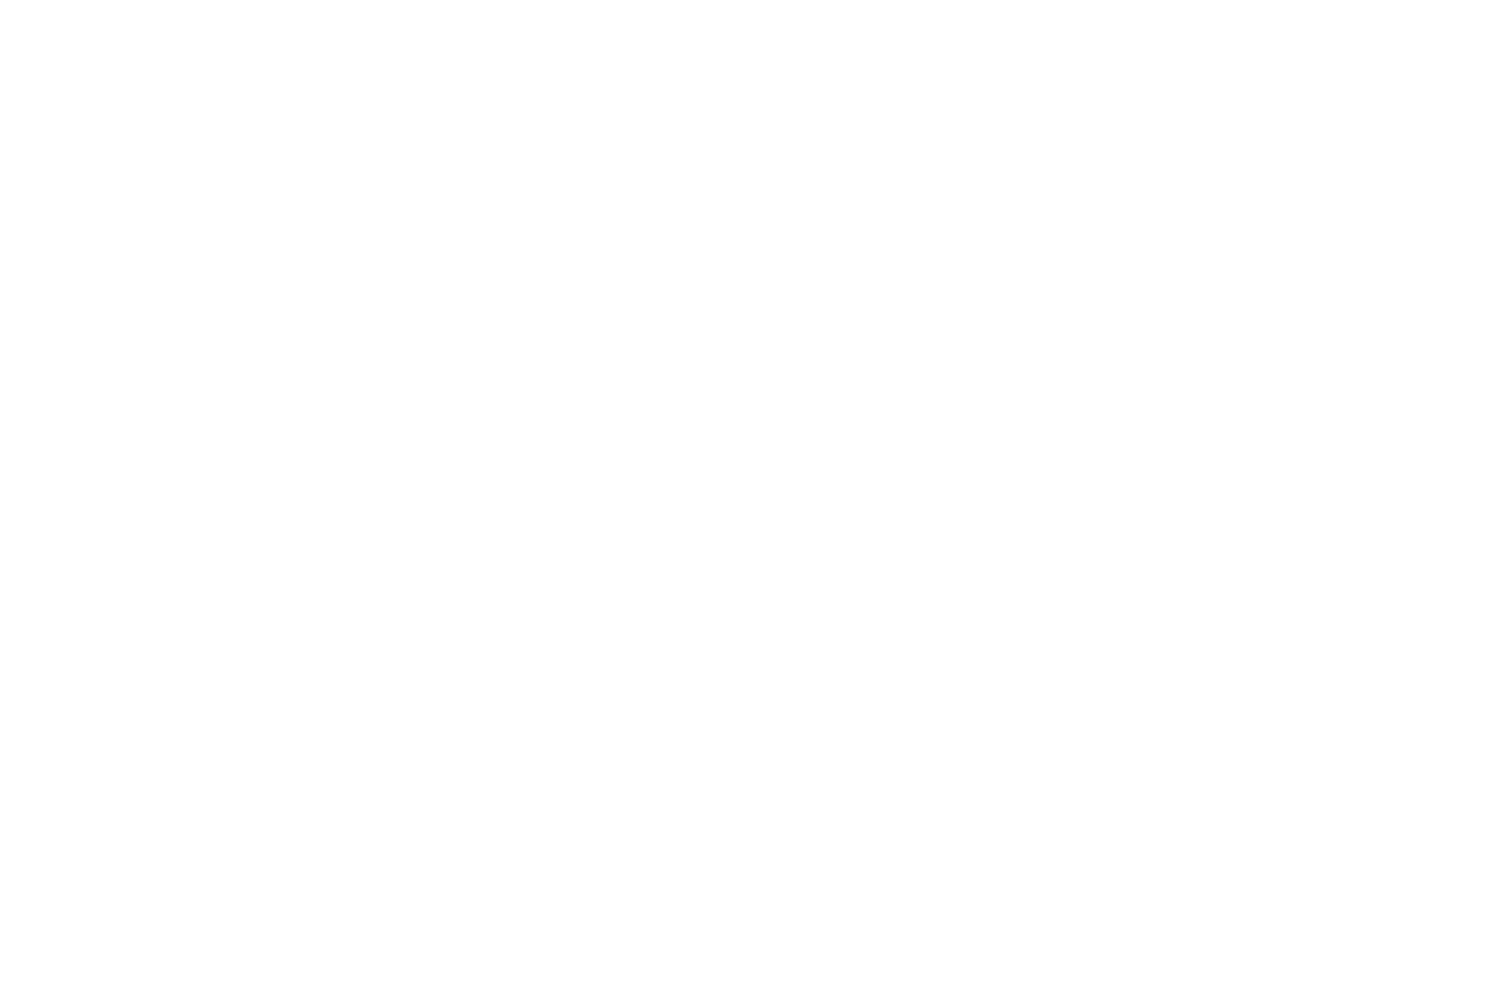

{'name': 'HOPS-140', 'frequency': 33000000000.0, 'flux': 0.0001537}


<IPython.core.display.Javascript object>


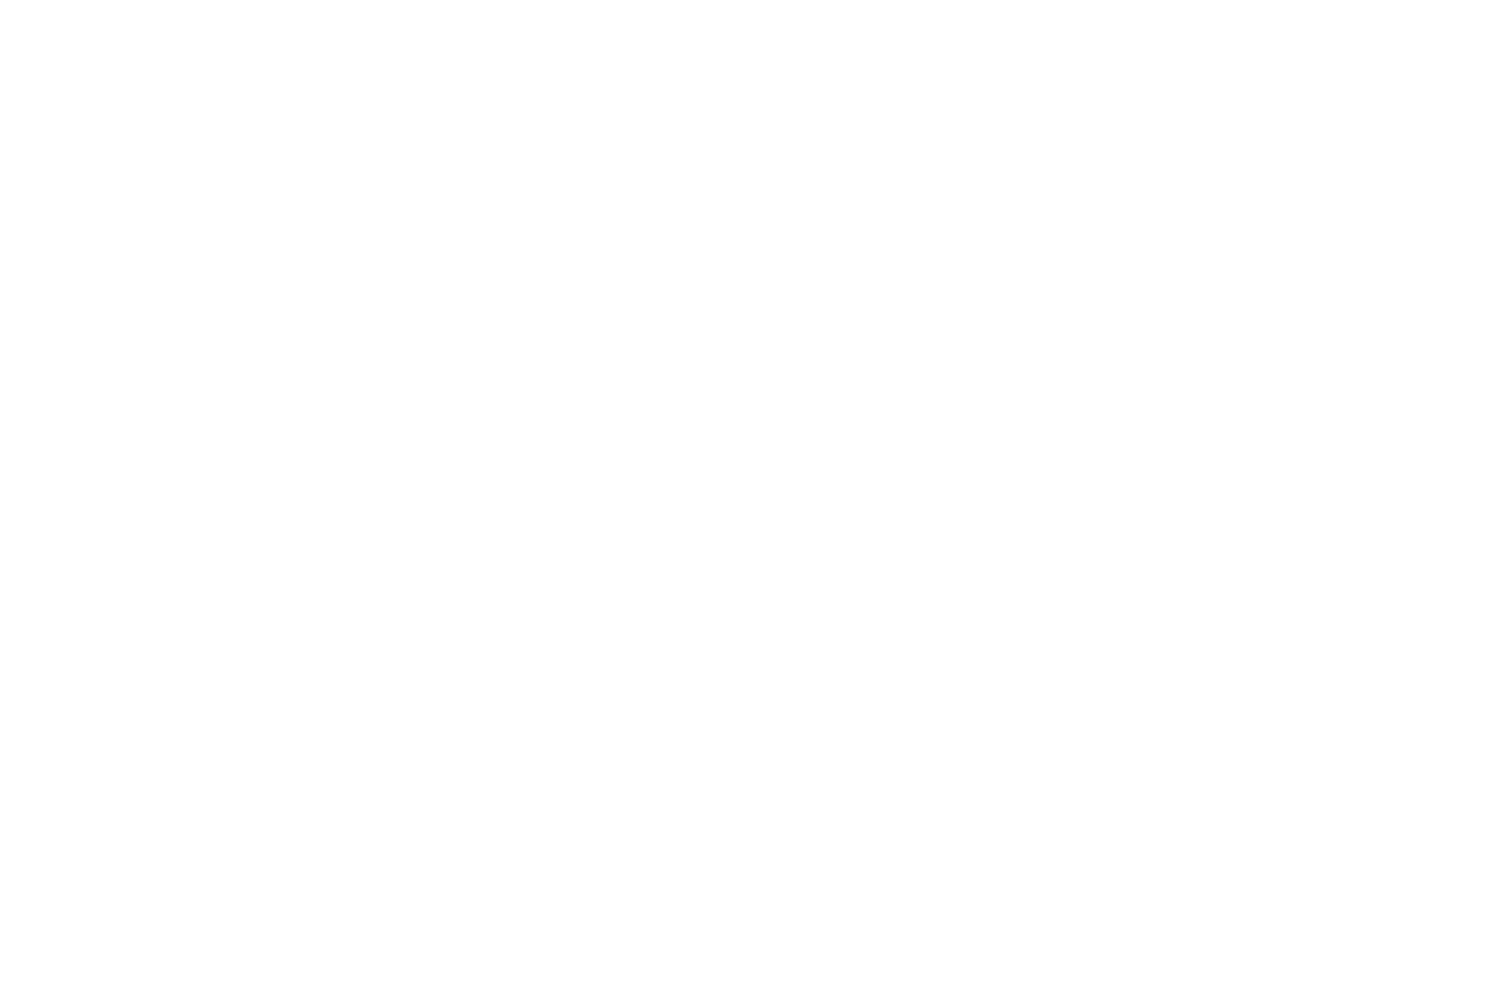

{'name': 'HOPS-140', 'frequency': 33000000000.0, 'flux': 2.262e-05}


<IPython.core.display.Javascript object>


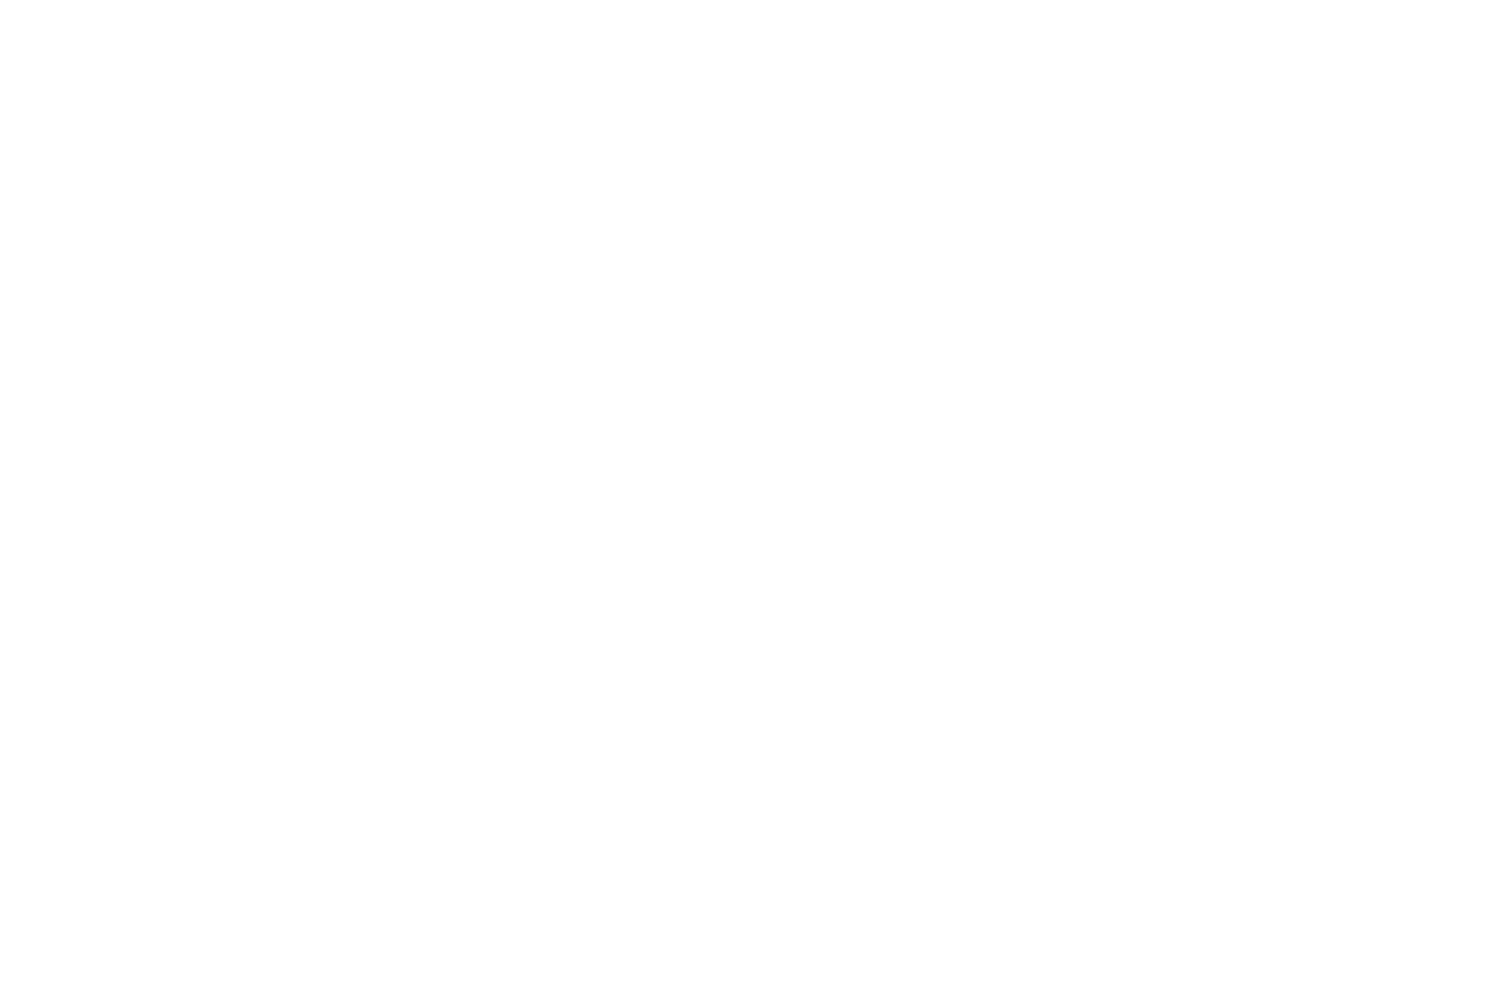

{'name': 'HOPS-157_a', 'frequency': 33000000000.0, 'flux': 2.67e-05}


<IPython.core.display.Javascript object>


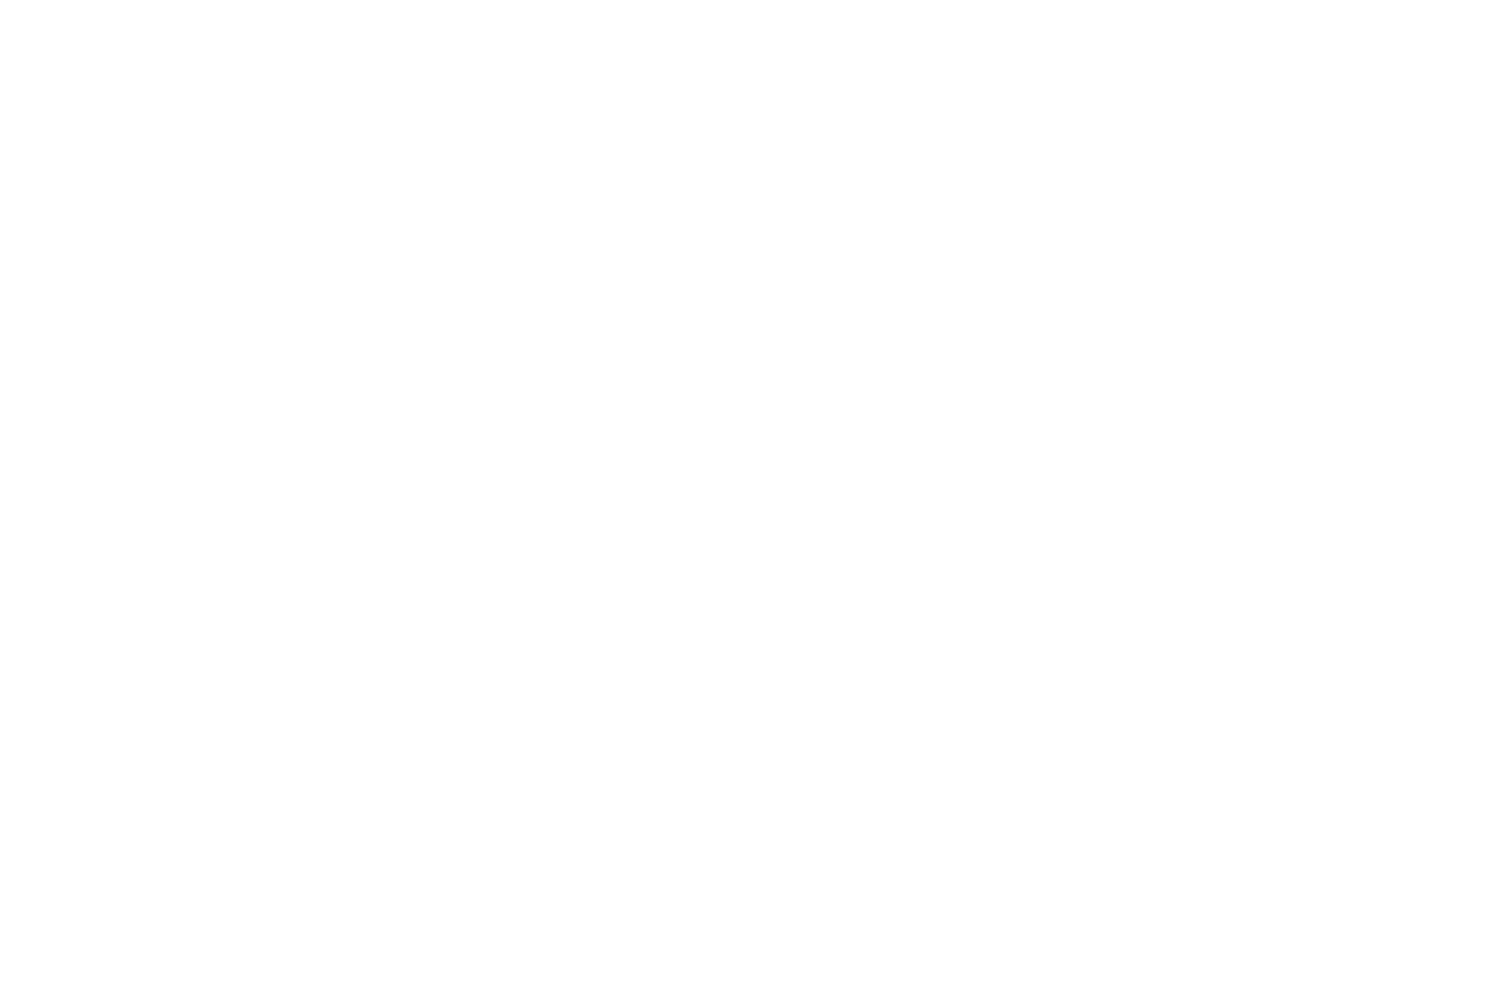

{'name': 'HOPS-157_b', 'frequency': 33000000000.0, 'flux': 2.34e-05}


<IPython.core.display.Javascript object>


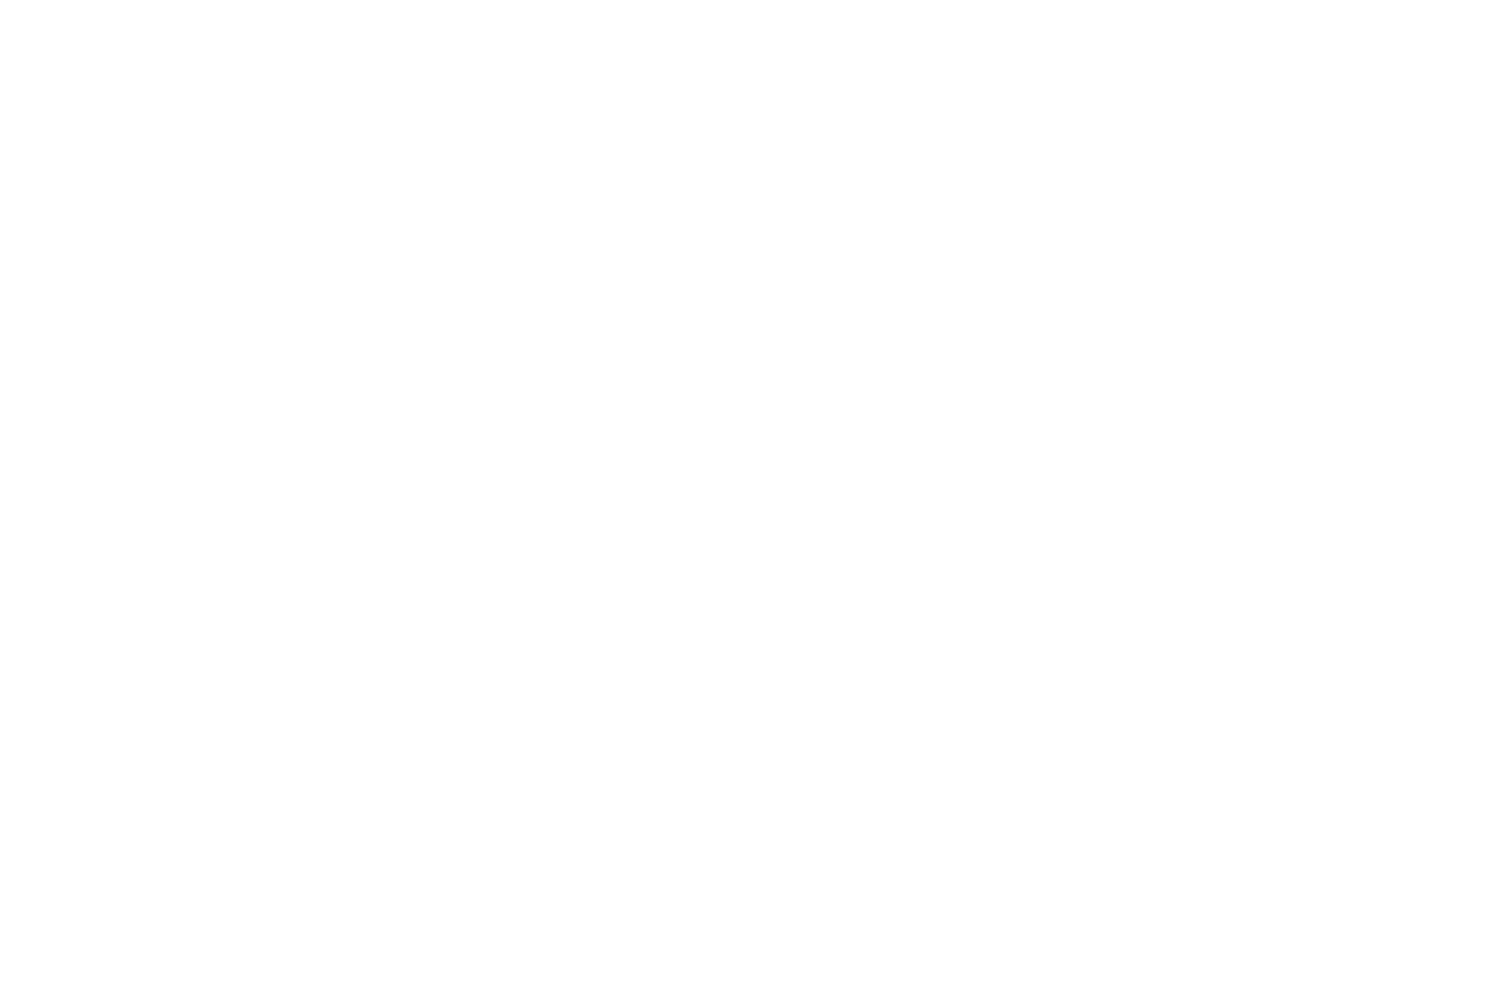

{'name': 'HOPS-157', 'frequency': 33000000000.0, 'flux': 2.8470000000000004e-05}


<IPython.core.display.Javascript object>


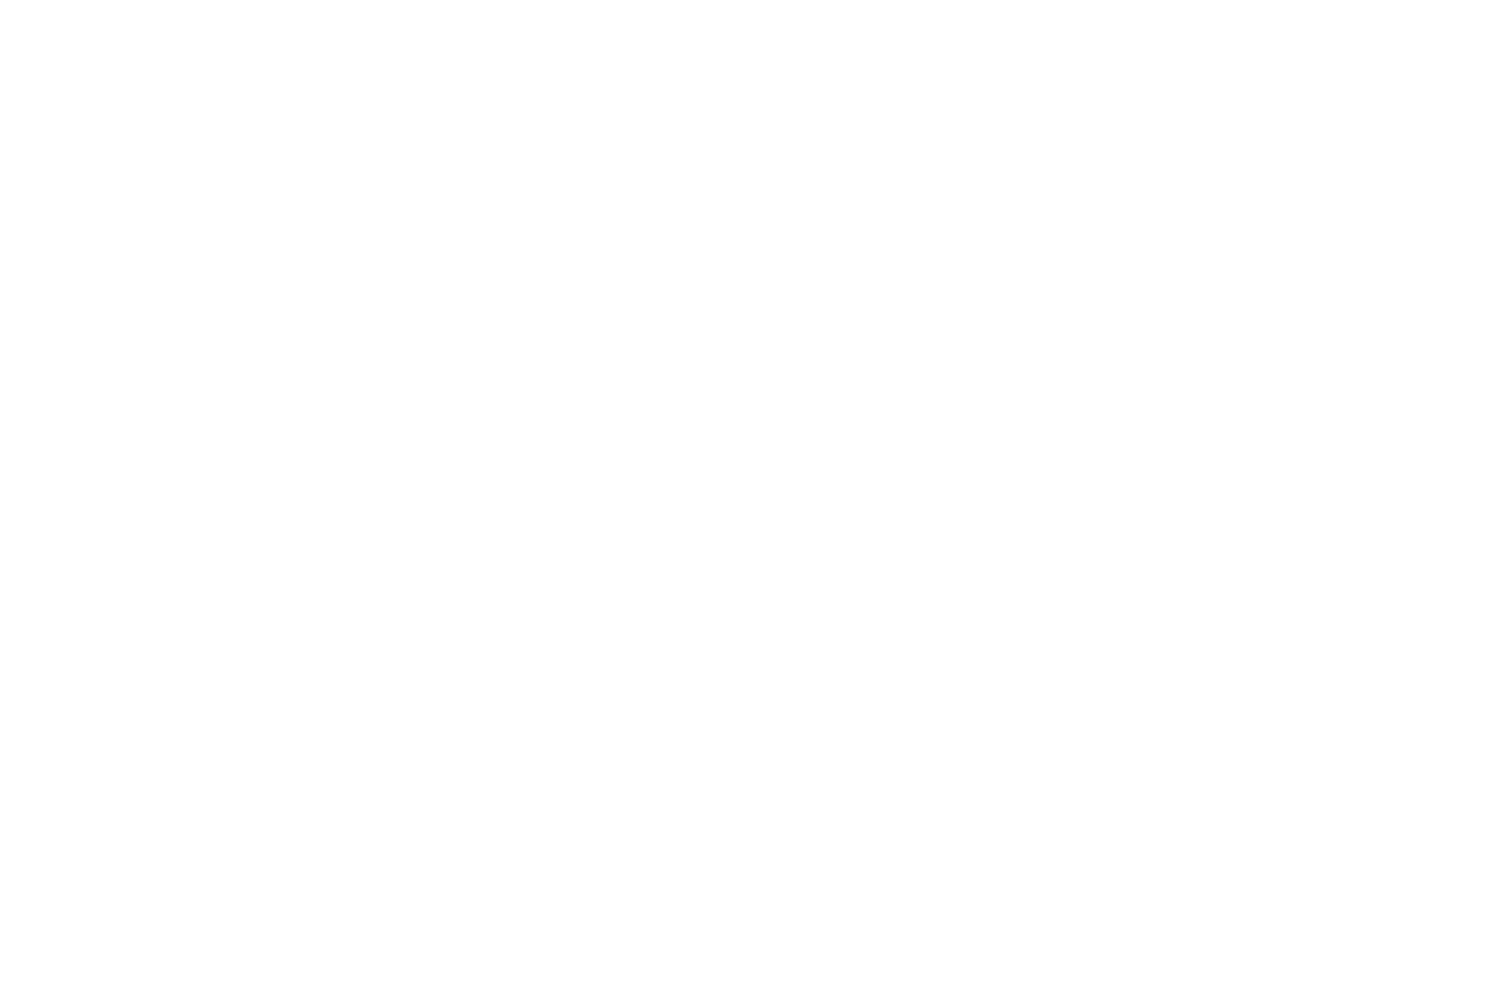

{'name': 'HOPS-163', 'frequency': 33000000000.0, 'flux': 1.461e-05}


<IPython.core.display.Javascript object>


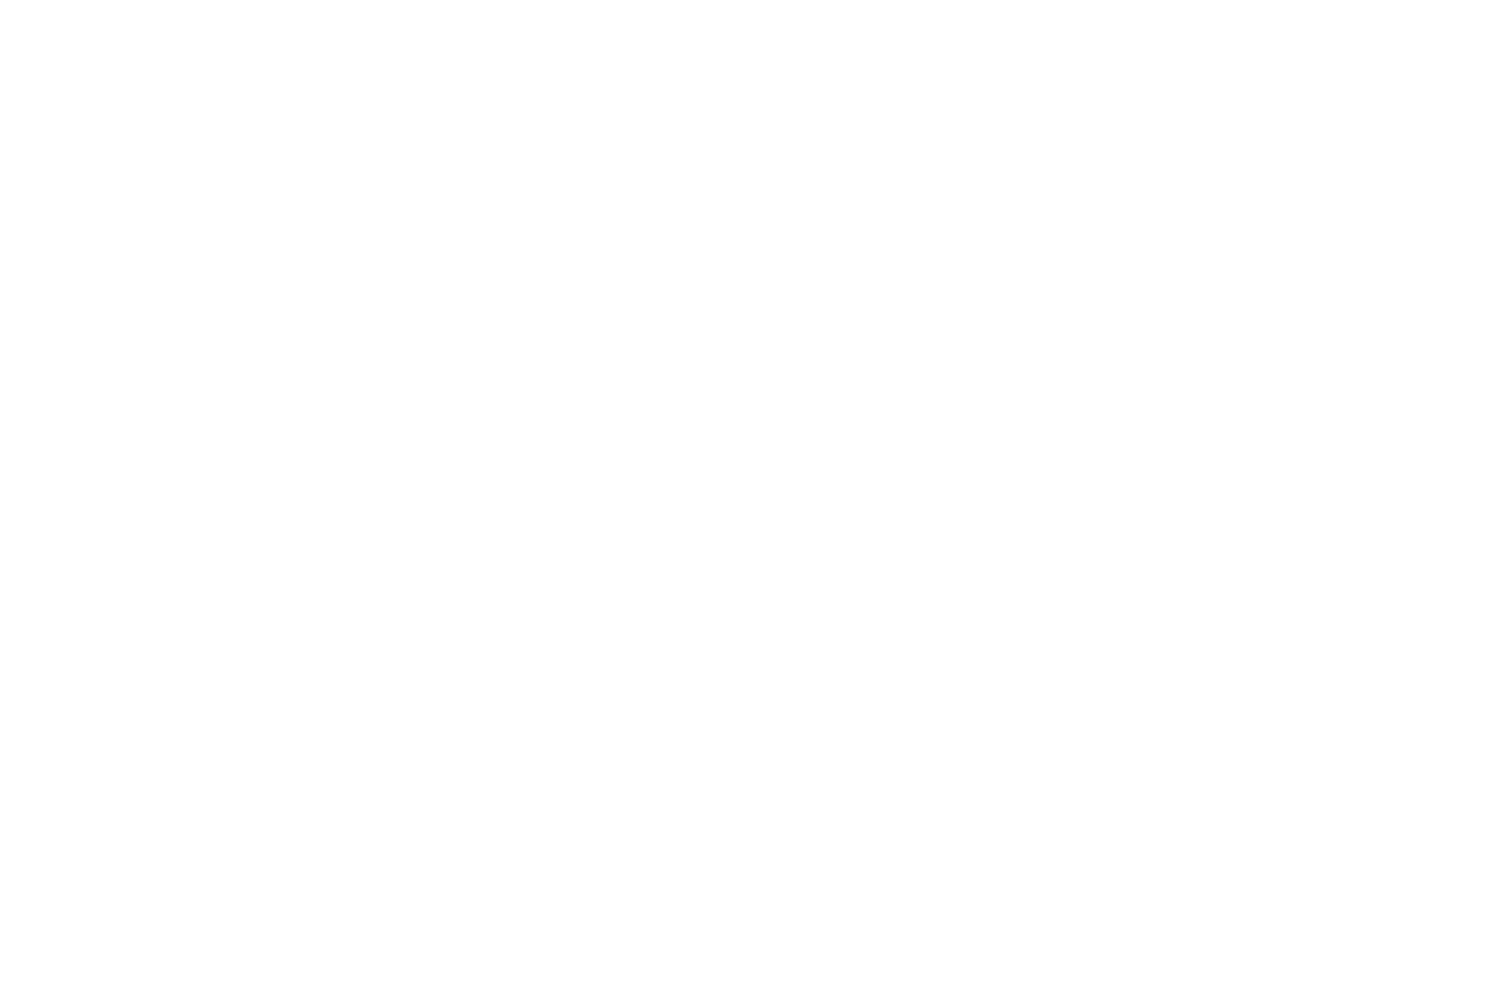

{'name': 'HH270MMS2', 'frequency': 44000000000.0, 'flux': 2.6249999999999998e-05}


<IPython.core.display.Javascript object>


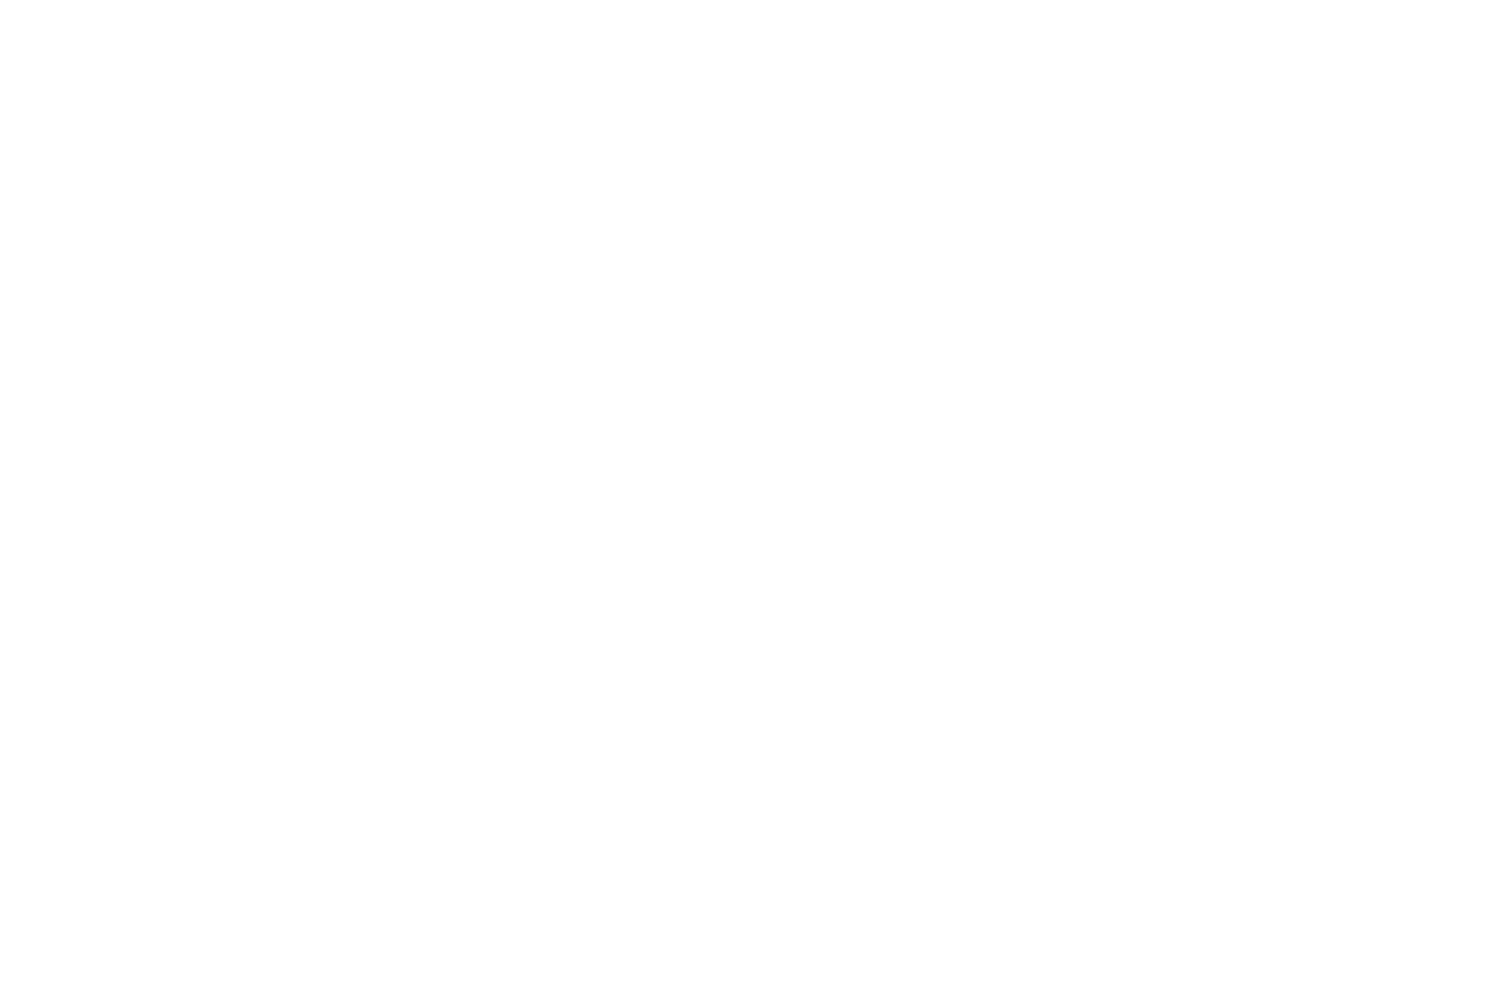

In [23]:
obj_56 = {'name': 'HOPS-56', 'frequency': 33.0e9, 'flux':5.69e-5}
obj_65 = {'name': 'HOPS-65', 'frequency': 15.0e9, 'flux':1.064e-5}
obj_124 = {'name': 'HOPS-124', 'frequency': 44.0e9, 'flux': 0.0005424}
obj_140 = {'name': 'HOPS-140', 'frequency': 33.0e9, 'flux':0.0001537}
obj_157_a = {'name': 'HOPS-157_a', 'frequency': 33.0e9, 'flux':2.67e-5}
obj_157_b = {'name': 'HOPS-157_b', 'frequency': 33.0e9, 'flux':2.34e-5}
obj_163_3RMS = {'name': 'HOPS-163', 'frequency': 33.0e9, 'flux':4.87e-6*3}
obj_270_3RMS = {'name': 'HH270MMS2', 'frequency': 44.0e9, 'flux':8.75e-6*3}

obj_56_3RMS = {'name': 'HOPS-56', 'frequency': 33.0e9, 'flux':7.81e-6*3}
obj_65_3RMS = {'name': 'HOPS-65', 'frequency': 15.0e9, 'flux':2.44e-6*3}
obj_124_3RMS = {'name': 'HOPS-124', 'frequency': 44.0e9, 'flux': 6.54e-5*3}
obj_140_3RMS = {'name': 'HOPS-140', 'frequency': 33.0e9, 'flux':7.54e-6*3}
obj_157_3RMS = {'name': 'HOPS-157', 'frequency': 33.0e9, 'flux':9.49e-6*3}


objs = [obj_56, obj_56_3RMS, obj_65, obj_65_3RMS, obj_124, obj_56_3RMS, obj_140, obj_140_3RMS, obj_157_a, obj_157_b, obj_157_3RMS, obj_163_3RMS, obj_270_3RMS]


for obj in objs:
    print(obj)
    lam_in = 3.0e8/(obj['frequency'])
    lam_out = 4.1e-2
    fluxin = obj['flux']
    flux_41_01 = find_flux(fluxin*1000, lam_in, lam_out, -0.1)
    flux_41_051 = find_flux(fluxin*1000, lam_in, lam_out, 0.51)

    trac = ["BHAC15","Siess2000",  "Dotter2008", "Tognelli2011","Feiden2016","Feiden2016mag","Chen2014","Bressan2012"]

    L_bol_056, L_mean_056, L_std_056 = monte_carlo(flux=flux_41_051, D=0.4)
    L_bol_n01, L_mean_n01, L_std_n01 = monte_carlo(flux=flux_41_01, D=0.4)

    mass_al_trac_1y = np.empty(len(trac), dtype=object)
    mass_al_trac_1yn = np.empty(len(trac), dtype=object)
    mass_al_trac_05y = np.empty(len(trac), dtype=object)
    mass_al_trac_05yn = np.empty(len(trac), dtype=object)

    for track in trac: 
        mass_al_trac_1y[trac.index(track)] = pms_get_mstar(age = 1.0e6, luminosity= L_bol_056, tracks=track)
        mass_al_trac_1yn[trac.index(track)] = pms_get_mstar(age = 1.0e6, luminosity= L_bol_n01, tracks=track)
        mass_al_trac_05y[trac.index(track)] = pms_get_mstar(age = 0.5e6, luminosity=L_bol_056, tracks=track)
        mass_al_trac_05yn[trac.index(track)] = pms_get_mstar(age = 0.5e6, luminosity= L_bol_n01, tracks=track)

    plot_violin(mass_al_trac_1y, mass_al_trac_1yn, mass_al_trac_05y, mass_al_trac_05yn, obj['name'])

In [33]:
from astropy.table import Table
t = Table()
# t['object'] = ['HOPS-56','HOPS-56_3RMS','HOPS-65','HOPS-65_3RMS','HOPS-124','HOPS-124_3RMS','HOPS-140','HOPS-140_3RMS','HOPS-157_a','HOPS-157_a_3RMS','HOPS-157_b','HOPS-157_b_3RMS','HOPS-163_3RMS','HH270-MMS2_3RMS']

obj_56 = {'name': 'HOPS-56', 'frequency': 33.0e9, 'flux':5.69e-5}
obj_65 = {'name': 'HOPS-65', 'frequency': 15.0e9, 'flux':1.064e-5}
obj_124 = {'name': 'HOPS-124', 'frequency': 44.0e9, 'flux': 0.0005424}
obj_140 = {'name': 'HOPS-140', 'frequency': 33.0e9, 'flux':0.0001537}
obj_157_a = {'name': 'HOPS-157_a', 'frequency': 33.0e9, 'flux':2.67e-5}
obj_157_b = {'name': 'HOPS-157_b', 'frequency': 33.0e9, 'flux':2.34e-5}
obj_163_3RMS = {'name': 'HOPS-163_3RMS', 'frequency': 33.0e9, 'flux':4.87e-6*3}
obj_270_3RMS = {'name': 'HH270MMS2_3RMS', 'frequency': 44.0e9, 'flux':8.75e-6*3}

obj_56_3RMS = {'name': 'HOPS-56_3RMS', 'frequency': 33.0e9, 'flux':7.81e-6*3}
obj_65_3RMS = {'name': 'HOPS-65_3RMS', 'frequency': 15.0e9, 'flux':2.44e-6*3}
obj_124_3RMS = {'name': 'HOPS-124_3RMS', 'frequency': 44.0e9, 'flux': 6.54e-5*3}
obj_140_3RMS = {'name': 'HOPS-140_3RMS', 'frequency': 33.0e9, 'flux':7.54e-6*3}
obj_157_3RMS = {'name': 'HOPS-157_3RMS', 'frequency': 33.0e9, 'flux':9.49e-6*3}


objs = [obj_56, obj_56_3RMS, obj_65, obj_65_3RMS, obj_124, obj_56_3RMS, obj_140, obj_140_3RMS, obj_157_a, obj_157_b, obj_157_3RMS, obj_163_3RMS, obj_270_3RMS]
t['object'] = [objs[i]['name'] for i in range(len(objs))]
t['flux'] = [objs[i]['flux'] for i in range(len(objs))]

bol_056 = []
bol_n01 = []
m_1y = []
m_1yn =[]
m_05y = []
m_05yn = []
trac = ["BHAC15","Siess2000",  "Dotter2008", "Tognelli2011","Feiden2016","Feiden2016mag","Chen2014","Bressan2012"]

for i in range(len(objs)):
    print(objs[i])
    lam_in = 3.0e8/(objs[i]['frequency'])
    lam_out = 4.1e-2
    fluxin = objs[i]['flux']
    flux_41_01 = find_flux(fluxin*1000, lam_in, lam_out, -0.1)
    flux_41_051 = find_flux(fluxin*1000, lam_in, lam_out, 0.51)
    

    L_bol_056, L_mean_056, L_std_056 = monte_carlo(flux=flux_41_051, D=0.4)
    L_bol_n01, L_mean_n01, L_std_n01 = monte_carlo(flux=flux_41_01, D=0.4)
    
    bol_056.append(L_mean_056)
    bol_n01.append(L_mean_n01)
    

    mass_al_trac_1y = np.empty(len(trac), dtype=object)
    mass_al_trac_1yn = np.empty(len(trac), dtype=object)
    mass_al_trac_05y = np.empty(len(trac), dtype=object)
    mass_al_trac_05yn = np.empty(len(trac), dtype=object)
    m_1y.append([])
    m_1yn.append([])
    m_05y.append([])
    m_05yn.append([])
    for j in range(len(trac)): 
        mass_al_trac_1y[j] = pms_get_mstar(age = 1.0e6, luminosity= L_bol_056, tracks=trac[j])
  
        m_1y[i].append([np.percentile(mass_al_trac_1y[j],50),\
                        (np.percentile(mass_al_trac_1y[j],95)-np.percentile(mass_al_trac_1y[j],50)),\
                        (np.percentile(mass_al_trac_1y[j],50)-np.percentile(mass_al_trac_1y[j],5))])
        
        mass_al_trac_1yn[j] = pms_get_mstar(age = 1.0e6, luminosity= L_bol_n01, tracks=trac[j])
        m_1yn[i].append([np.percentile(mass_al_trac_1yn[j],50),\
                        (np.percentile(mass_al_trac_1yn[j],95)-np.percentile(mass_al_trac_1yn[j],50)),\
                         (np.percentile(mass_al_trac_1yn[j],50)-np.percentile(mass_al_trac_1yn[j],5))])
        
        mass_al_trac_05y[j] = pms_get_mstar(age = 0.5e6, luminosity=L_bol_056, tracks=trac[j])
        m_05y[i].append([np.percentile(mass_al_trac_05y[j],50),\
                        (np.percentile(mass_al_trac_05y[j],95)-np.percentile(mass_al_trac_05y[j],50)),\
                        (np.percentile(mass_al_trac_05y[j],50)-np.percentile(mass_al_trac_05y[j],5))])
        
        mass_al_trac_05yn[j] = pms_get_mstar(age = 0.5e6, luminosity= L_bol_n01, tracks=trac[j])
        m_05yn[i].append([np.percentile(mass_al_trac_05yn[j],50),\
                        (np.percentile(mass_al_trac_05yn[j],95)-np.percentile(mass_al_trac_05yn[j],50)),\
                        (np.percentile(mass_al_trac_05yn[j],50)-np.percentile(mass_al_trac_05yn[j],5))])

#     plot_violin(mass_al_trac_1y, mass_al_trac_1yn, mass_al_trac_05y, mass_al_trac_05yn, objs[i]['name'])

{'name': 'HOPS-56', 'frequency': 33000000000.0, 'flux': 5.69e-05}
{'name': 'HOPS-56_3RMS', 'frequency': 33000000000.0, 'flux': 2.3429999999999998e-05}
{'name': 'HOPS-65', 'frequency': 15000000000.0, 'flux': 1.064e-05}
{'name': 'HOPS-65_3RMS', 'frequency': 15000000000.0, 'flux': 7.319999999999999e-06}
{'name': 'HOPS-124', 'frequency': 44000000000.0, 'flux': 0.0005424}
{'name': 'HOPS-56_3RMS', 'frequency': 33000000000.0, 'flux': 2.3429999999999998e-05}
{'name': 'HOPS-140', 'frequency': 33000000000.0, 'flux': 0.0001537}
{'name': 'HOPS-140_3RMS', 'frequency': 33000000000.0, 'flux': 2.262e-05}
{'name': 'HOPS-157_a', 'frequency': 33000000000.0, 'flux': 2.67e-05}
{'name': 'HOPS-157_b', 'frequency': 33000000000.0, 'flux': 2.34e-05}
{'name': 'HOPS-157_3RMS', 'frequency': 33000000000.0, 'flux': 2.8470000000000004e-05}
{'name': 'HOPS-163_3RMS', 'frequency': 33000000000.0, 'flux': 1.461e-05}
{'name': 'HH270MMS2_3RMS', 'frequency': 44000000000.0, 'flux': 2.6249999999999998e-05}


In [34]:
m_1y

[[[1.0369654686711356, 0.23838798700986974, 0.1944861967989573],
  [0.9170082214426014, 0.2422742517819605, 0.2366998673953844],
  [1.038453348216838, 0.2311517064747548, 0.1843838203447924],
  [0.8445321693060883, 0.293625595396662, 0.27008539549176047],
  [0.9590284230033099, 0.22922695202192056, 0.18228055361185258],
  [1.232239491925124, 0.19445998505746154, 0.1999050857953919],
  [0.9771716077905117, 0.23010572572271348, 0.1848643785659757],
  [0.9764050694920721, 0.22962331787943824, 0.18482532280703423]],
 [[0.5586929537245595, 0.11972810260403333, 0.11143601910299478],
  [0.3935689226607949, 0.1554868519124437, 0.1082341190863495],
  [0.5920880661524299, 0.10897694923075263, 0.10763615154764328],
  [0.37112518030663666, 0.06214420148570782, 0.056154890548095915],
  [0.5008978268435313, 0.12135347774899474, 0.17237942185527966],
  [0.6670987888380799, 0.15930108668592857, 0.265726258674636],
  [0.5690218145550621, 0.10464015905150814, 0.10324405698668965],
  [0.526831731112732, 

In [ ]:
err_u = []
err_b = []
m_mean = []
for track in trac:
    p_95 = (np.percentile(mass_al_trac_41[trac.index(track)],95))
    p_5 = (np.percentile(mass_al_trac_41[trac.index(track)],5))
    p_50 =(np.percentile(mass_al_trac_41[trac.index(track)],50))
    err_u.append(p_95 - p_50)
    err_b.append(p_50 - p_5)
    m_mean.append(p_50)
    